In [1]:
n_fold = 1
total_fold = '5'
use_enchanced_dataset = True

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model
import util

tf.compat.v1.disable_eager_execution()

2022-11-17 00:43:14.698739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 00:43:14.938044: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 00:43:15.638612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cries/.conda/envs/Nabil_env/lib/
2022-11-17 00:43:15.638725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

In [5]:
labels = ['No Findings',
          'Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER)
def check_for_leakage(df1, df2, patient_col):    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    if patients_in_both_groups:
        leakage = True # boolean (true if there is at least 1 patient in both groups)
    else:
        leakage = False
    return leakage

In [7]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'Image Index')))

leakage between train and test: False


In [8]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320): 
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [9]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"

In [10]:
def get_test_generator(test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image Index",
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [11]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", labels)
test_generator= get_test_generator(test_df, train_df, IMAGE_DIR, "Image Index", labels)

getting train generator...
Found 4484 validated image filenames.
getting train generators...
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


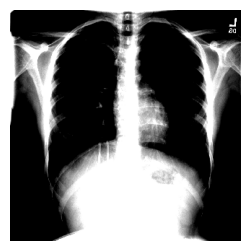

In [12]:
x, y = train_generator.__getitem__(0)
plt.figure(figsize=(5,3))
plt.axis('off')
plt.imshow(x[0]);

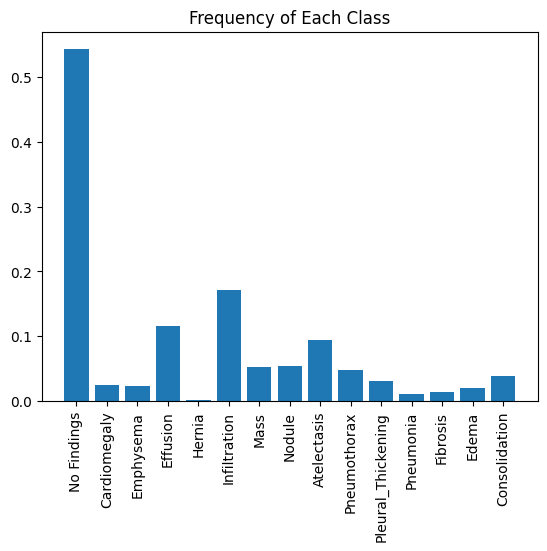

In [13]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [14]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [15]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

/tmp/ipykernel_18962/2978771470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


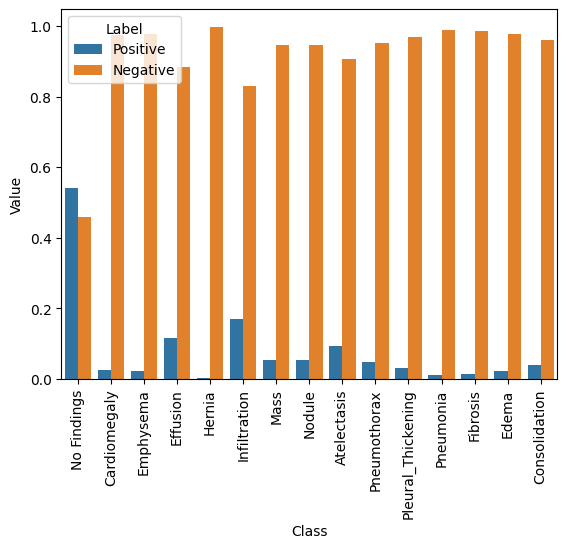

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

/tmp/ipykernel_18962/4211278599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


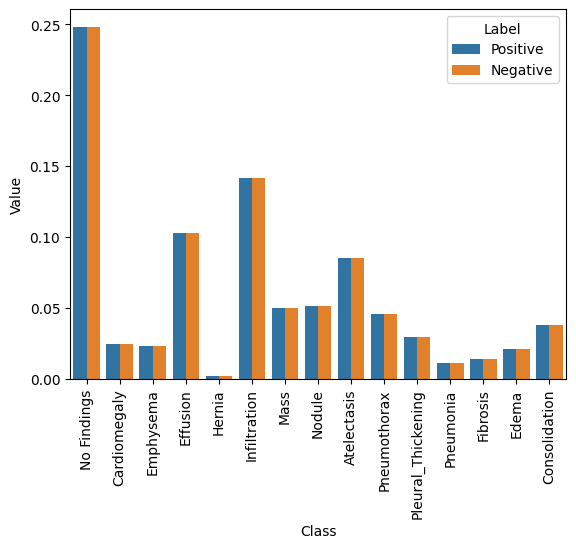

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [19]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss

    return weighted_loss

In [20]:
# create the base pre-trained model
base_model = DenseNet121(weights='/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
Colocations handled automatically by placer.


2022-11-17 00:43:30.893111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 00:43:32.095053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18661 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2022-11-17 00:43:32.492706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [21]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

Epoch 1/2


/tmp/ipykernel_18962/3406673253.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-11-17 00:44:29.654761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-17 00:44:31.442676: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-17 00:44:31.446162: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-17 00:44:31.446206: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-17 00:44:31.446326: W tensorflow/str

561/561 [==============================] - 229s 333ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2763
Epoch 2/2
561/561 [==============================] - 184s 327ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2441


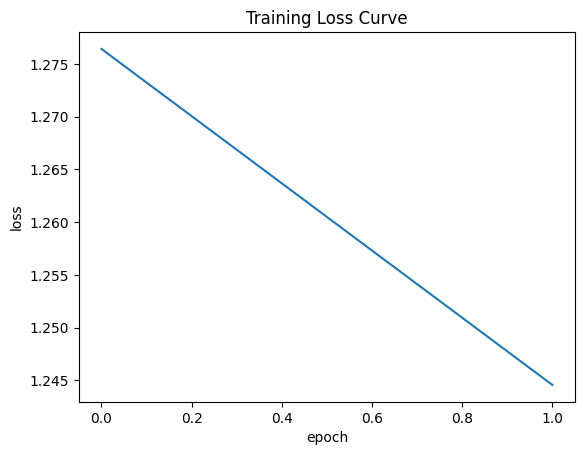

In [22]:
history = model.fit_generator(train_generator, 
                              #validation_data=valid_generator,
                              #steps_per_epoch=100, # to limit step
                              #validation_steps=25, 
                              epochs = 2)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

### Training on the Larger Dataset 

load pre-trained weights
- ModelCheckpoint (monitor val_loss)
- TensorBoard (to monitor my runs in real-time)
- ReduceROnPlateau (to slowly decay the learning rate)
- EarlyStopping (to stop training when my model stops getting better)

In [23]:
# model.load_weights("/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels.h5")

### Prediction and Evaluation

In [24]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

/tmp/ipykernel_18962/2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
/home/cries/.conda/envs/Nabil_env/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### ROC Curve and AUROC

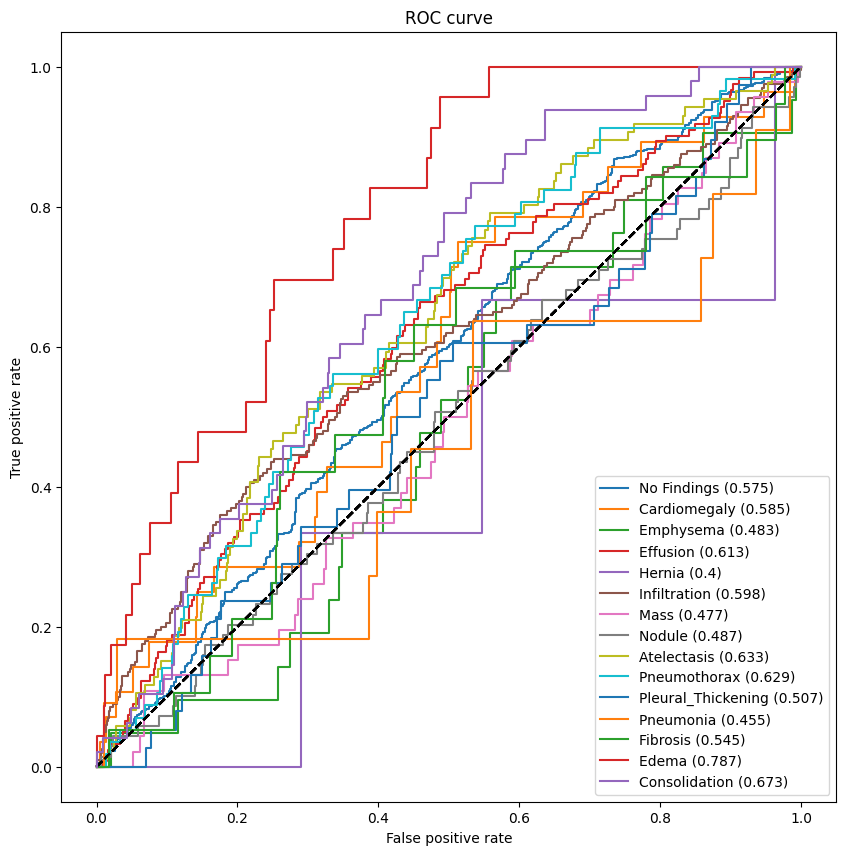

In [25]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [26]:
#release memory GPU
from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


### Visualizing Learning with GradCAM

In [27]:
# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [28]:
util.compute_gradcam(model, '00000013_005.png', IMAGE_DIR, train_df, labels, labels_to_show)

: 

: 